In [1]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from scipy import interp

In [2]:
data_folder = '../data/csv_data/'
extension = '.csv.gz'
build_path = lambda x: data_folder + x + extension

cv_token_pattern = u'[^;]+'

In [3]:
def train_plot_roc(X, y, n_splits=10):
    # Trying ROC
    skf = StratifiedKFold(n_splits=n_splits)
    classifier = LogisticRegression(C=1)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10, 4), dpi=100)

    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(figsize=(10, 4), dpi=100)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 0.25])
    plt.ylim([0.50, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return (mean_fpr, mean_tpr, classifier)

In [4]:
goodware = pd.read_csv(build_path('goodware_real'), dtype=str).set_index('link')
malware = pd.read_csv(build_path('malware_real'), dtype=str).set_index('link')

In [5]:
big_dataset = pd.read_csv(build_path('learn_behav_categories_bigrams')).set_index('link')
malware_labeled = pd.read_csv(build_path('malware_labeled'), dtype=str).set_index('link').astype(float)
big_dataset = big_dataset.loc[(big_dataset.malware == 0) | (big_dataset.index.isin(malware_labeled.index))]
big_dataset = big_dataset[((big_dataset.index.isin(malware.index)) & (big_dataset.malware == 1)) |
            ((big_dataset.index.isin(goodware.index)) & (big_dataset.malware == 0))]

In [6]:
valid_samples = pd.read_csv(build_path('all_samples')).set_index('link').index
big_dataset = big_dataset.loc[big_dataset.index.isin(valid_samples)]

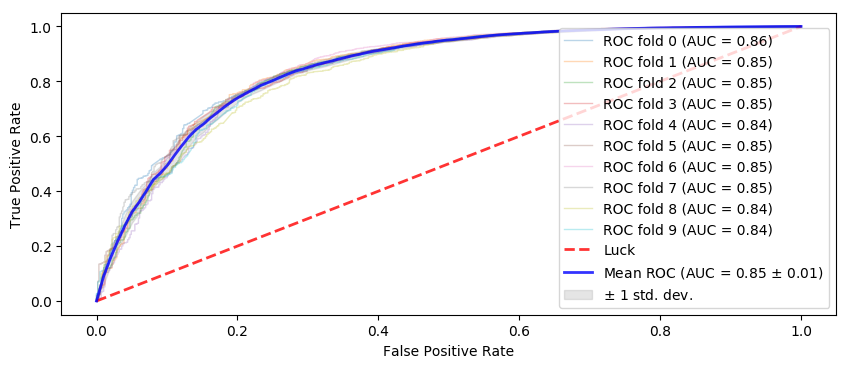

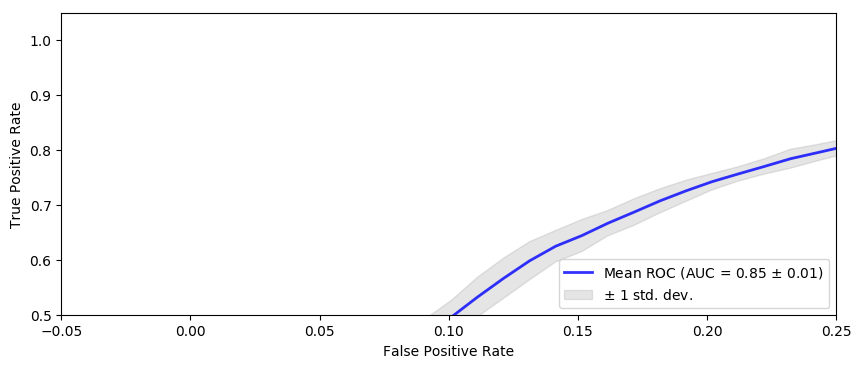

CPU times: user 4min 43s, sys: 5.6 s, total: 4min 48s
Wall time: 4min 42s


In [7]:
%%time
data = shuffle(big_dataset)
train_plot_roc(np.array(data.iloc[:, :-1]), data.malware)

In [8]:
mal_classes = list(malware_labeled.columns)

datasets = dict()
for mclass in mal_classes:
    mal = malware_labeled[mclass].dropna()
    #mal = malware_labeled[~malware_labeled[mclass].isna()].index
    #mal = malwr_pe32[malwr_pe32.md5.isin(mal)]
    #mal = mal[~mal.index.isin(goodware.index)]
    datasets[mclass] = mal.index

'Testing other...'

'other: 40468'

'other: 53459'

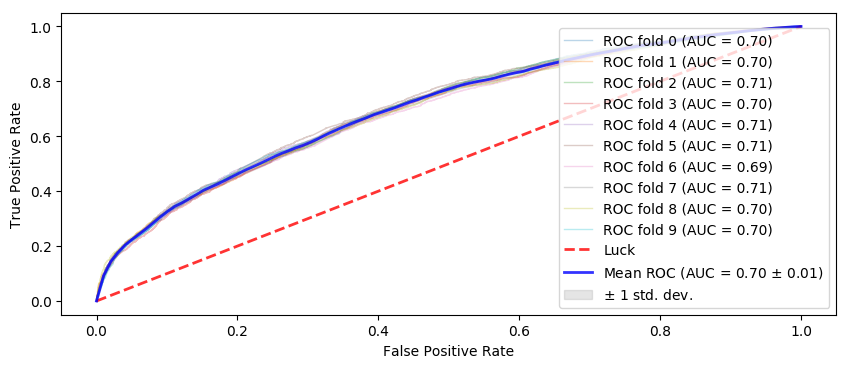

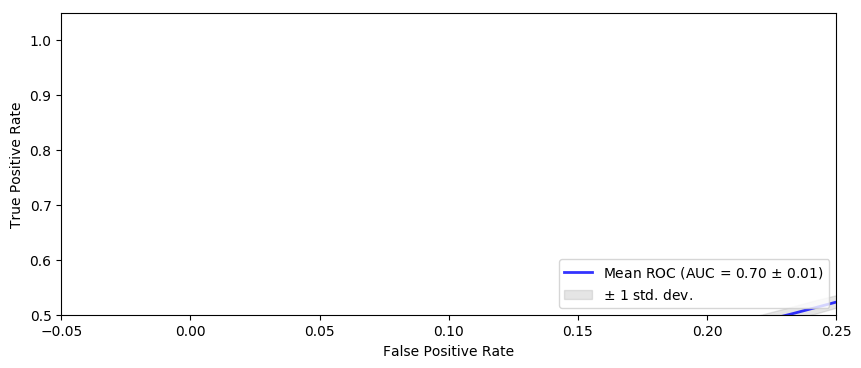

'Testing ransom...'

'ransom: 6786'

'other: 87141'

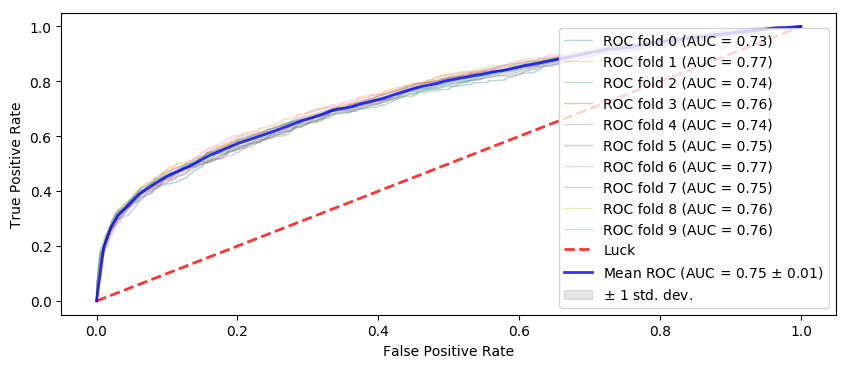

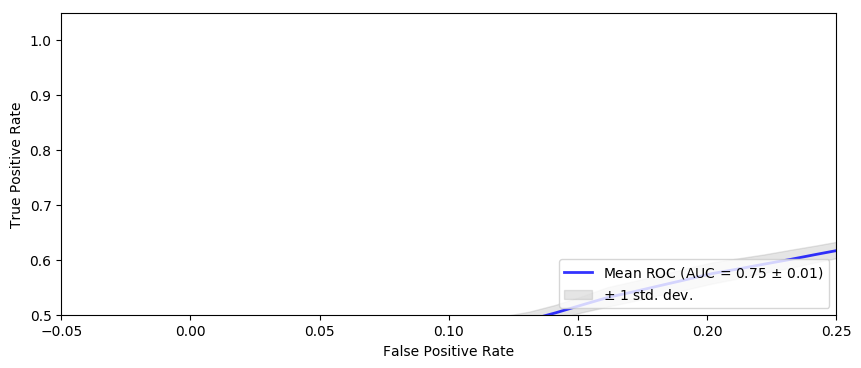

'Testing spyware...'

'spyware: 17287'

'other: 76640'

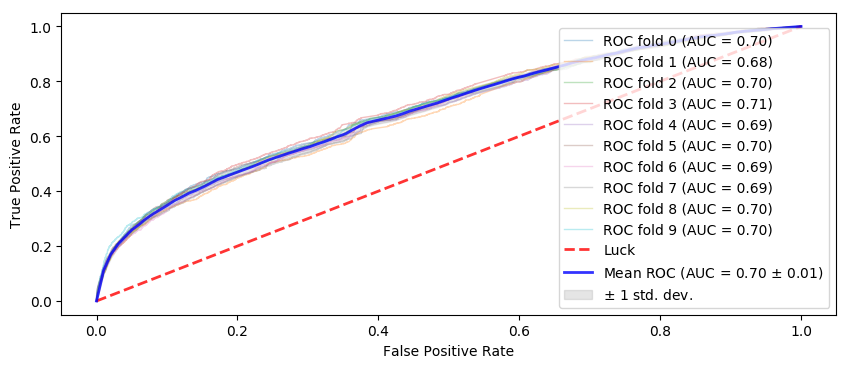

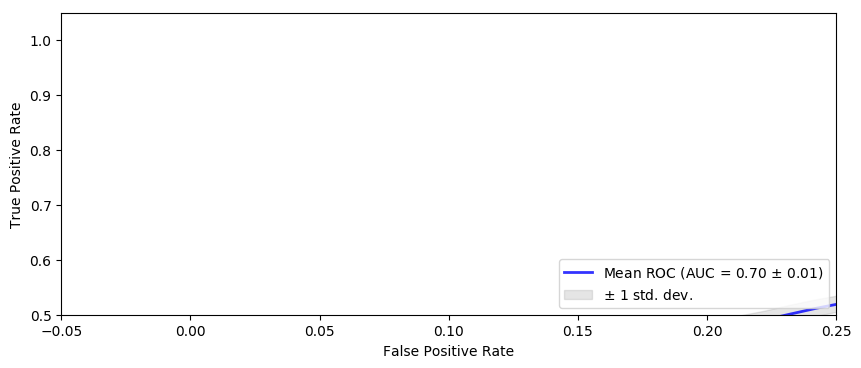

'Testing trojan...'

'trojan: 86568'

'other: 7359'

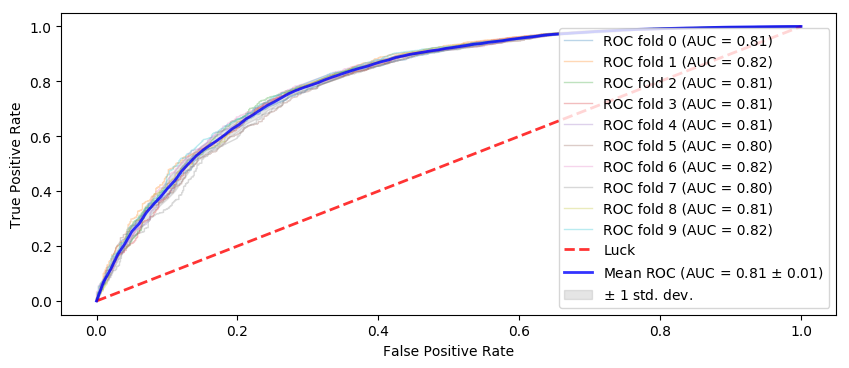

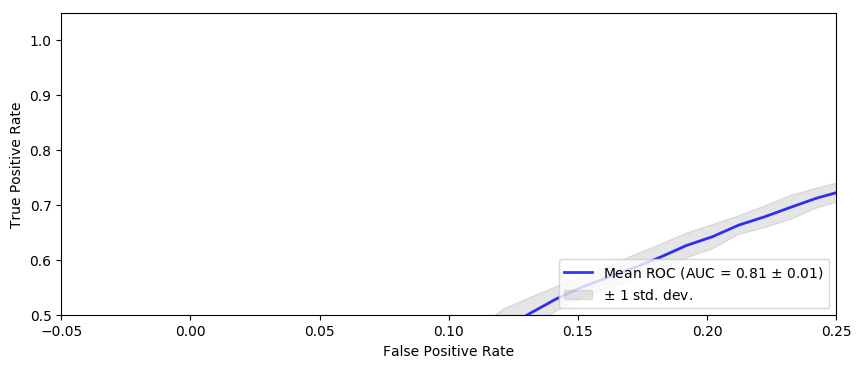

'Testing virus...'

'virus: 17162'

'other: 76765'

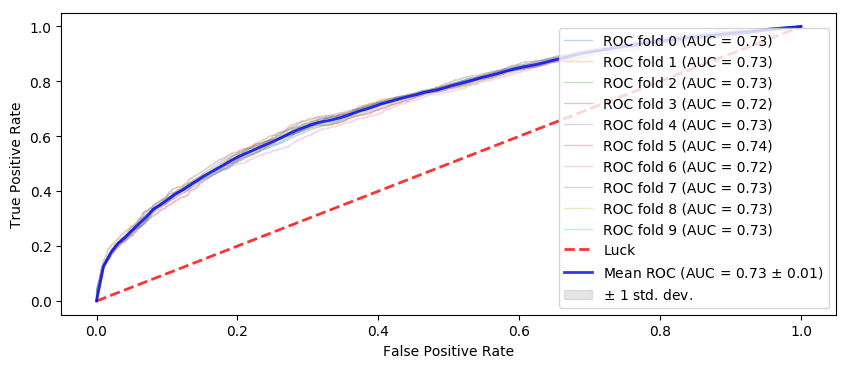

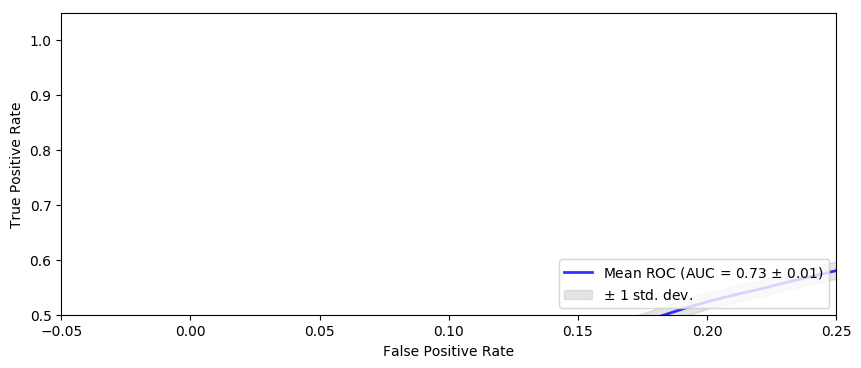

'Testing worm...'

'worm: 19779'

'other: 74148'

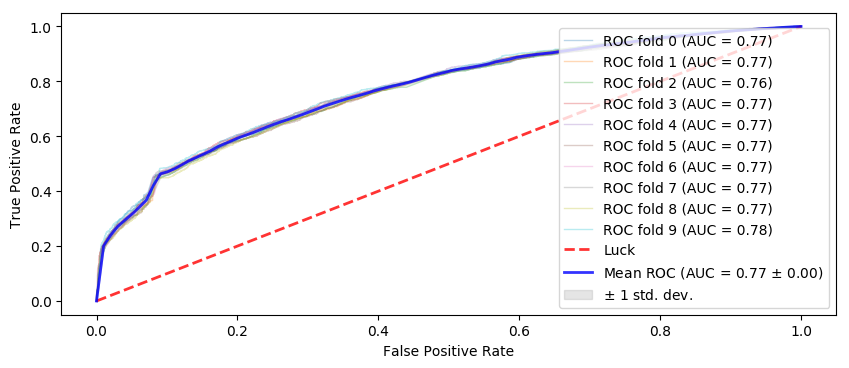

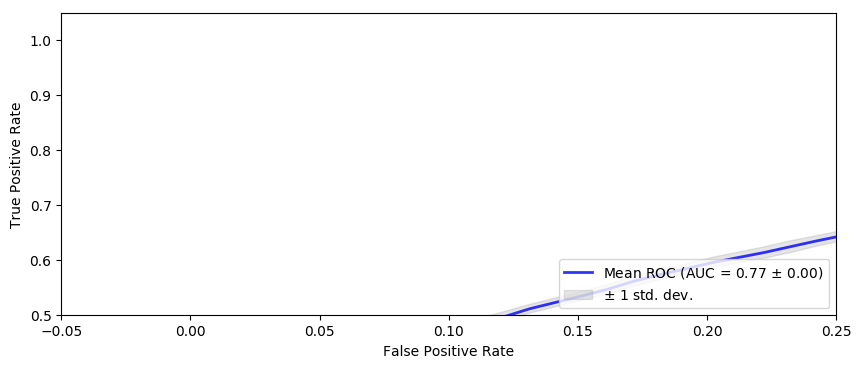

CPU times: user 30min 32s, sys: 36.6 s, total: 31min 8s
Wall time: 30min 24s


In [9]:
%%time
classifiers = dict()
final_rocs = dict()
for mclass in mal_classes:
    display('Testing {}...'.format(mclass))

    mal = big_dataset[(big_dataset.malware == True) & (big_dataset.index.isin(datasets[mclass]))]
    mal.is_copy = False
    mal.loc[:, 'malware'] = True
    not_mal = big_dataset[~(big_dataset.index.isin(datasets[mclass]))]
    not_mal.is_copy = False
    not_mal.loc[:, 'malware'] = False
    
    data = shuffle(pd.concat([mal, not_mal]))
    display('{}: {}'.format(mclass, len(mal)))
    display('other: {}'.format(len(not_mal)))
    assert len(big_dataset) == len(data)
    
    X = np.array(data.iloc[:, :-1])
    y = data.malware
    mean_fpr, mean_tpr, classifier = train_plot_roc(X, y)
    final_rocs[mclass] = (mean_fpr, mean_tpr)
    classifiers[mclass] = classifier.fit(X, y)

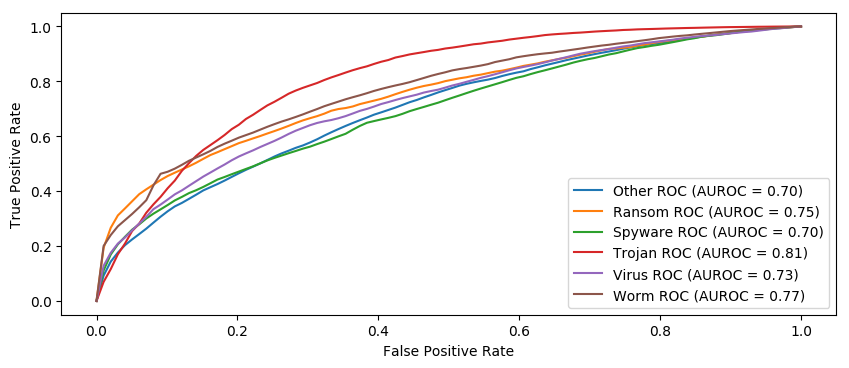

In [10]:
plt.figure(figsize=(10, 4), dpi=100)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
for mclass in mal_classes:
    plt.plot(final_rocs[mclass][0],
             final_rocs[mclass][1],
             label='{} ROC (AUROC = {:.2f})'.format(mclass.capitalize(), auc(final_rocs[mclass][0], final_rocs[mclass][1])))
plt.legend(loc="lower right")
plt.show()

In [11]:
# Join to big_dataset classification from smaller classifiers
X = big_dataset.iloc[:, :-1]
big_dataset2 = pd.DataFrame(columns=mal_classes, index=big_dataset.index)
for mclass in mal_classes:
    probs = classifiers[mclass].predict_proba(X)[:,1]
    results = pd.DataFrame(index=big_dataset.index, data=classifiers[mclass].predict_proba(X)[:,1], columns=[mclass])
    big_dataset2.loc[:, mclass] = results
big_dataset2.loc[:, 'malware'] = big_dataset.malware

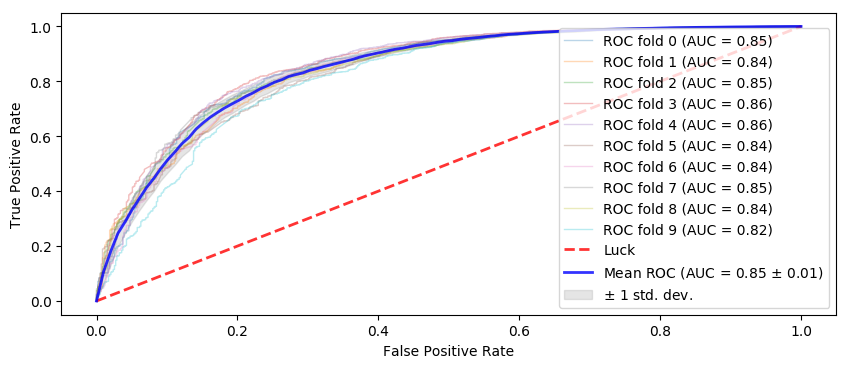

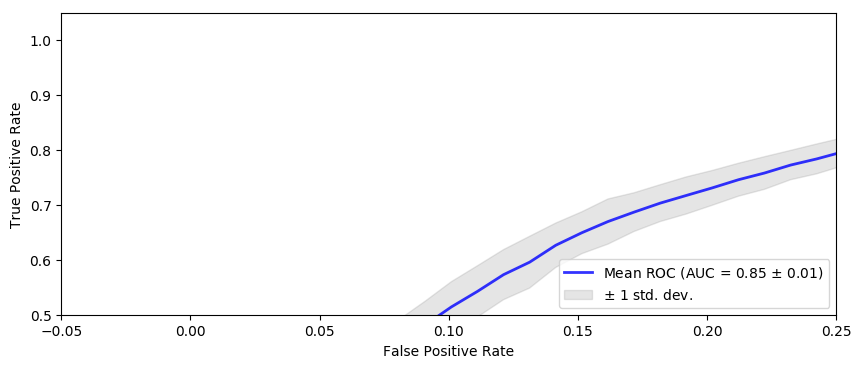

In [13]:
data = shuffle(big_dataset2)
_ = train_plot_roc(np.array(data.iloc[:, :-1]), data.malware)